In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from fooof import FOOOF
from fooof.sim import gen_power_spectrum
from scipy.io import loadmat

from easydict import EasyDict as edict
from tqdm import trange

plt.style.use('ggplot')
plt.rcParams["savefig.bbox"] = "tight"

In [19]:
# My own pkgs
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT
from hdf_utils.data_gen import gen_simu_psd, gen_covs
from utils.misc import save_pkl, load_pkl

from splines import obt_bsp_basis_Rfn
from projection import euclidean_proj_l1ball

In [18]:
import importlib
import hdf_utils.data_gen
importlib.reload(hdf_utils.data_gen)

<module 'hdf_utils.data_gen' from '/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/hdf_utils/data_gen.py'>

## Load True PSD

In [4]:
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')                                                                                              
ind_psd = ind_psd_xr.values
ind_freq = ind_psd_xr["frequencies"].values

In [5]:
# PSD from AD vs Ctrl
dat_AD = loadmat(DATA_ROOT/"87ADs_before_filter1000_PSD.mat")["fmegall"]
dat_AD_add = loadmat(DATA_ROOT/"DK_timecourse_PSD.mat")["FMEGdata"]
dat_AD = np.concatenate([dat_AD, dat_AD_add[np.newaxis]], axis=0)
dat_AD = np.transpose(dat_AD, (1, 2, 0))

dat_ctrl = loadmat(DATA_ROOT/"70Ctrls_before_filter1000_PSD.mat")["fmegall"]
dat_ctrl_add = loadmat(DATA_ROOT/"timecourse_ucsfCONT_group_PSD.mat")["fmegall"]
dat_ctrl = np.concatenate([dat_ctrl, dat_ctrl_add], axis=0)
dat_ctrl = np.transpose(dat_ctrl, (1, 2, 0))

ind_freq = np.linspace(1, 40, 40)
dat_all = np.concatenate([dat_AD, dat_ctrl], axis=-1)

In [6]:
# some parameters
paras = edict()
paras.npts = 40 # num of pts to evaluate X(s)
paras.d = 68 # num of ROIs
paras.q = 5 # num of other covariates
paras.M = 10 # num of data obs to be genareted

paras.bsp = edict()
paras.bsp.aknots_raw = np.linspace(0, 1, 20)
paras.bsp.iknots = paras.bsp.aknots_raw[1:-1]
paras.bsp.bknots = np.array([0, 1])
paras.bsp.ord = 4

paras.bsp.x = np.linspace(0, 1, paras.npts)
#paras.bsp.x = np.linspace(0, 1, paras.npts+1)[:-1]
paras.bsp.basis_mat = obt_bsp_basis_Rfn(paras.bsp.x, 
                                        paras.bsp.iknots, 
                                        paras.bsp.bknots, 
                                        paras.bsp.ord)
paras.bsp.N = paras.bsp.basis_mat.shape[1] # num of basis for bsp

## Generate PSD

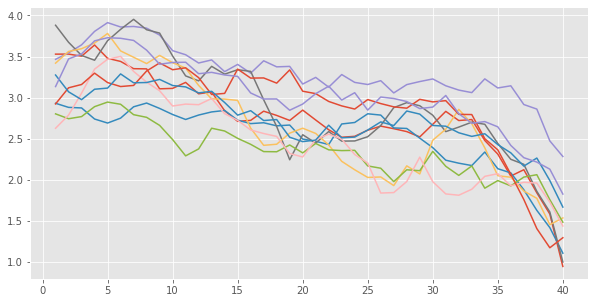

In [194]:
plt.figure(figsize=[10, 5])
for ix in range(10):
    plt.plot(ind_freq, np.log10(dat_all[67, :, ix]))

## Generate beta(s)

In [9]:
basis_mat = paras.bsp.basis_mat
d = paras.d
N = paras.bsp.N

Gam_GT = np.random.randn(N, d)
beta_mat = basis_mat @ Gam_GT
beta_mat = np.asarray(beta_mat.T)

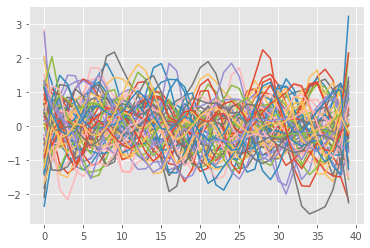

In [10]:
for ix in range(68):
    plt.plot(beta_mat[ix, :])

In [11]:
int_part = np.sum(beta_mat * dat[:, :, :], axis=1).mean(axis=1)
int_part

array([ 0.41732587,  0.01677725,  0.54503766,  0.46251822, -0.36826393,
       -0.20337539,  0.64182433,  0.28849824, -0.03012111, -0.27889521])

## Generate covs

In [15]:
types_ = [2, 2, "c", "c", "c"]
gen_covs(paras.M, types_)

array([[ 0.        ,  0.        ,  0.98367925,  0.18441152, -0.27468126],
       [ 1.        ,  1.        ,  1.98122513, -0.81681259,  1.16283868],
       [ 0.        ,  1.        ,  1.85301163,  0.53189331, -1.57346404],
       [ 1.        ,  0.        ,  0.53898134,  0.43757611, -0.06802926],
       [ 1.        ,  1.        , -0.25846361,  0.62688431,  1.62866223],
       [ 0.        ,  0.        ,  0.00333602, -0.44514948, -0.10047418],
       [ 1.        ,  0.        ,  0.9646105 , -1.15601835,  0.2495467 ],
       [ 0.        ,  1.        , -1.1599202 ,  0.72090559,  0.52741057],
       [ 1.        ,  0.        , -1.03435282, -0.97665669,  2.5012779 ],
       [ 0.        ,  0.        , -0.32429899, -0.90895783, -0.16481409]])